## Train the PF-controller neural networ

For each performance metric train the corresponding pf-controller neural network

In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
from src.models.normal import NormalDegradationModel as NModel
from src.models.particle_filter import ParticleFilterModel,ParticleFilterMLP

## Task

In [ ]:
data_name = "DS03"
perform_name = 'SmLPC'

device = "cpu"
pf_dir_name = 'pf_perform_forgetlik1_multn0.05_fullprior_128x128x64x32leaky0.05'

## Hyper-Parameters

In [3]:
n_particles = 1600
multiply_scale = 0.05
start_idx = 1
hidden_dims=[128, 128, 64,32]
activation = nn.LeakyReLU(0.05)

# Training parameters
n_epochs = 10000
acc_epochs = 5
patience = 200          # how many eval steps to wait
min_delta = 1e-4       # minimum improvement to count

In [4]:
experiment_dir = Path('experiments')/data_name
pf_dir = experiment_dir/pf_dir_name
checkpoint_path = pf_dir / perform_name / "checkpoint.pt"
checkpoint_path.parent.mkdir(parents=True, exist_ok=True)

## Import training data

In [5]:
hi_df = pd.read_csv(experiment_dir/'hidata_dev.csv')
units = hi_df['unit'].astype(int).unique().tolist()
units 

[1, 2, 3, 4, 5, 6, 7, 8, 9]

### Extract degradation onset

In [6]:
onsets = {unit: hi_df[(hi_df['unit']==unit) & (hi_df['hs']==0)]['cycle'].values[0] for unit in units}
del hi_df['hs']

In [7]:
perform_names = [col for col in hi_df.columns if col not in ['unit','cycle']]

performs = {name: 
    {unit: hi_df[hi_df['unit']==unit][name].values for unit in units} 
    for name in perform_names
}
time = {unit: hi_df[hi_df['unit']==unit]['cycle'].values for unit in units}

## Create component (base) models

In [8]:
eval_data = {}
eval_eol = {}
for unit in units:
    t_data = time[unit]
    s_data = performs[perform_name][unit]
    eval_data[unit]=torch.tensor(np.stack([t_data, s_data],axis=1),dtype=torch.float32).to(device)
    eval_eol[unit]=torch.tensor(t_data[-1],dtype=torch.float32) 


In [9]:
train_degmodels = {}
for eval_unit in units:
    degmodels=[]
    for unit, perform in performs[perform_name].items():
        if unit == eval_unit:
            continue
        best_model = NModel(onset=onsets[unit])
        best_model.load_state_dict(
            torch.load(experiment_dir/'states'/perform_name/f'unit_{unit}'/ "best_model.pt", map_location=device)
        )
        best_model.to(device)
        degmodels.append(best_model)
    train_degmodels[eval_unit] = degmodels

## Train Particle Filter Net()

In [10]:
net = ParticleFilterMLP(state_dim=NModel.state_dim(), hidden_dims=hidden_dims,
                        activation=lambda : activation).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer.zero_grad()

In [11]:
wait = 0             
early_stop = False

start_epoch = 0
best_loss = float("inf")
total_loss = 0.0
losses = []
epochs = []

if checkpoint_path.exists():
    ckpt = torch.load(checkpoint_path, map_location=device)

    net.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])

    start_epoch = ckpt["epoch"] + 1
    best_loss = ckpt["best_loss"]
    losses = ckpt["losses"]
    epochs = ckpt["epochs"]

    print(f"✓ Resumed from epoch {start_epoch}, best_loss={best_loss:.3f}")

In [ ]:
for epoch in range(start_epoch, n_epochs):

    epoch_losses = []

    for eval_unit in np.random.permutation(units):
        optimizer.zero_grad()

        degmodels = train_degmodels[eval_unit]
        t_data = eval_data[eval_unit][:, 0]
        s_data = eval_data[eval_unit][:, 1]

        # --- fresh PF per unit ---
        pf = ParticleFilterModel(
            base_models=degmodels,
            net=net,
            n_particles=n_particles,
            multiply_scale=multiply_scale,
            name=perform_name,
        ).train()

        unit_loss = 0.0
        n_loss = 0

        # --- PF rollout ---
        for k in range(start_idx, len(t_data)):
            mixture_dist = pf.step(
                t_obs=t_data[:k],
                s_obs=s_data[:k],
            )

            last_dist = mixture_dist.distribution(s=s_data[-1:])
            nll = -last_dist.log_prob(t_data[-1:]).mean()

            unit_loss += nll
            n_loss += 1

        # --- normalize per unit ---
        unit_loss = unit_loss / n_loss

        # --- backprop per unit ---
        unit_loss.backward()
        optimizer.step()

        epoch_losses.append(unit_loss.item())

    # --- epoch summary ---
    current_loss = float(sum(epoch_losses) / len(epoch_losses))

    print(f"[Epoch {epoch:04d}] loss = {current_loss:.3f}")
    losses.append(current_loss)
    epochs.append(epoch)

    # --- early stopping & checkpoint ---
    if current_loss < best_loss - min_delta:
        best_loss = current_loss
        wait = 0

        checkpoint = {
            'epoch': epoch,
            'model_state': net.state_dict(),
            'best_state': net.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'best_loss': best_loss,
            'losses': losses,
            'epochs': epochs,
        }
        torch.save(checkpoint, checkpoint_path)
        print("  + saved (best)")

    else:
        wait += 1

        if wait >= patience:
            print("🛑 Early stopping triggered")
            early_stop = True

    if early_stop:
        break

[Epoch 0000] loss = 3.869
  + saved (best)
[Epoch 0001] loss = 4.015
[Epoch 0002] loss = 3.971
[Epoch 0003] loss = 3.808
  + saved (best)
[Epoch 0004] loss = 4.035
[Epoch 0005] loss = 3.788
  + saved (best)
[Epoch 0006] loss = 4.052
[Epoch 0007] loss = 3.849
[Epoch 0008] loss = 3.827
[Epoch 0009] loss = 3.810
[Epoch 0010] loss = 3.786
  + saved (best)
[Epoch 0011] loss = 3.859
[Epoch 0012] loss = 3.844
[Epoch 0013] loss = 3.843
[Epoch 0014] loss = 3.833
[Epoch 0015] loss = 3.795
[Epoch 0016] loss = 3.831
[Epoch 0017] loss = 3.825
[Epoch 0018] loss = 3.896
[Epoch 0019] loss = 3.874
[Epoch 0020] loss = 3.950
[Epoch 0021] loss = 3.992
[Epoch 0022] loss = 3.822
[Epoch 0023] loss = 3.823
[Epoch 0024] loss = 3.816
[Epoch 0025] loss = 3.830
[Epoch 0026] loss = 3.834
[Epoch 0027] loss = 3.863
[Epoch 0028] loss = 3.813
[Epoch 0029] loss = 3.830
[Epoch 0030] loss = 3.836
[Epoch 0031] loss = 3.801
[Epoch 0032] loss = 3.832
[Epoch 0033] loss = 3.770
  + saved (best)
[Epoch 0034] loss = 3.808
[Epoc

# Save last results

In [ ]:
if checkpoint_path.exists():
    ckpt:dict = torch.load(checkpoint_path, map_location=device)
    ckpt.update({
        'epoch': epoch,
        'model_state':net.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'losses': losses,
        'epochs': epochs,
    })
    torch.save(ckpt,checkpoint_path)

    print(f"✓ Resumed from epoch {start_epoch}, best_loss={best_loss:.3f}")

✓ Resumed from epoch 0, best_loss=3.644


## Plot

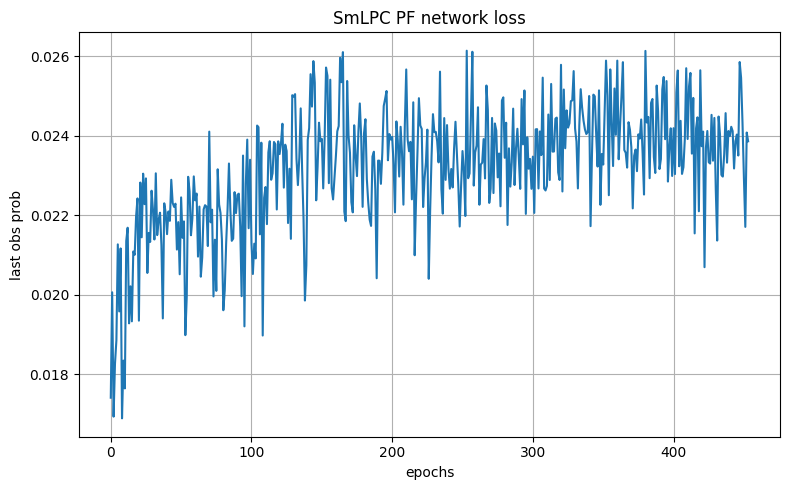

In [ ]:
likelihood = np.exp(-np.array(losses))

plt.figure(figsize=(8, 5))
plt.plot(epochs, likelihood)
plt.xlabel('epochs')
plt.ylabel('last obs prob')
plt.title(f'{perform_name} PF network loss')
plt.grid(True)

plt.tight_layout()
plt.savefig(pf_dir /perform_name/"net_training_loss.png", dpi=300) 
np.save(pf_dir /perform_name/"net_training_loss.npy", np.array(losses))
plt.show()